In [2]:
!pip -q install -U transformers datasets evaluate scikit-learn accelerate --progress-bar off
!pip install tensorflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [3]:
import urllib.request
import os, zipfile, glob, pandas as pd

url = 'https://github.com/devtlv/Datasets-GEN-AI-Bootcamp/raw/refs/heads/main/Week%206/W6D1%20GenAi%20France/Basics%20of%20BERT%20and%20XLM-RoBERTa%20-%20PyTorch%20-%202.zip'
output_zip = 'monfichier.zip'

urllib.request.urlretrieve(url, output_zip)

with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall('data')


In [4]:
root = glob.glob("data/*BERT*XLM*")[0]          # 'data/Basics of BERT and XLM-RoBERTa - PyTorch - 2'
print("root dir →", root, os.listdir(root))

root dir → data/Basics of BERT and XLM-RoBERTa - PyTorch ['train.csv.zip', 'test.csv.zip', 'sample_submission.csv']


In [5]:
for inner_zip in glob.glob(f"{root}/*.zip"):
    with zipfile.ZipFile(inner_zip) as z:
        z.extractall(root)                      # drops train.csv / test.csv next to the zips
    print("unzipped:", inner_zip)

unzipped: data/Basics of BERT and XLM-RoBERTa - PyTorch/train.csv.zip
unzipped: data/Basics of BERT and XLM-RoBERTa - PyTorch/test.csv.zip


In [6]:
TRAIN_CSV = f"{root}/train.csv"
TEST_CSV  = f"{root}/test.csv"      # will exist if the dataset shipped one
train_df = pd.read_csv(TRAIN_CSV)
print("\nTrain preview:\n", train_df.head())
print("\nLabel distribution:\n", train_df['label'].value_counts())
test_df = pd.read_csv(TEST_CSV) if os.path.exists(TEST_CSV) else None


Train preview:
            id                                            premise  \
0  5130fd2cb5  and these comments were considered in formulat...   
1  5b72532a0b  These are issues that we wrestle with in pract...   
2  3931fbe82a  Des petites choses comme celles-là font une di...   
3  5622f0c60b  you know they can't really defend themselves l...   
4  86aaa48b45  ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...   

                                          hypothesis lang_abv language  label  
0  The rules developed in the interim were put to...       en  English      0  
1  Practice groups are not permitted to work on t...       en  English      2  
2              J'essayais d'accomplir quelque chose.       fr   French      0  
3  They can't defend themselves because of their ...       en  English      0  
4    เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร       th     Thai      1  

Label distribution:
 label
0    4176
2    4064
1    3880
Name: count, dtype: int64


OK  label 0 : 	Entailment (implication)
    label 1 :   Neutral
    label 2 :   Contradiction

In [12]:
train_df.head()

,id,premise,hypothesis,lang_abv,language,label
0,f4891fa23f,Кто? Она спросила его с неожиданным интересом.,"Она спросила, как это сделать, так как с её то...",ru,Russian,1
1,e8b38c6175,Others are Zao (in Tohoku) and a number of res...,There are a lot of resorts in the national park.,en,English,0
2,e0a29d673a,trying to keep grass alive during a summer on ...,There was no cost in keeping the grass alive i...,en,English,2
3,26222ec767,so i guess my experience is is just with what ...,They were able to be home rather than having t...,en,English,0
4,d0cf40f417,The Journal put the point succinctly to Is an...,"The Journal asked ""Is this a good political mo...",en,English,1


Entailment (0): 4176 exemples
Neutral (1): 3880 exemples
Contradiction (2): 4064 exemples


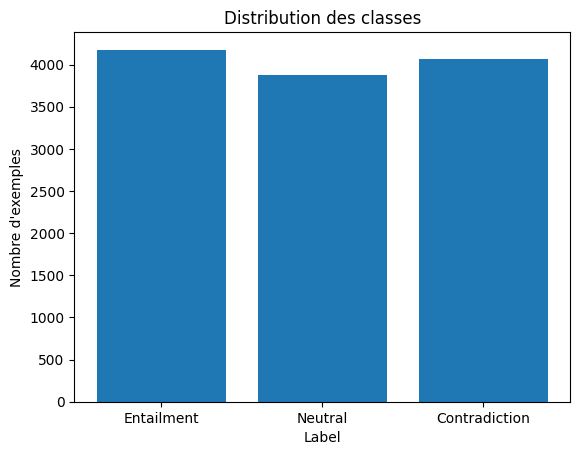

In [7]:
import matplotlib.pyplot as plt

label_counts = train_df['label'].value_counts().sort_index()
label_names = {0: "Entailment", 1: "Neutral", 2: "Contradiction"}

for label, count in label_counts.items():
    print(f"{label_names[label]} ({label}): {count} exemples")

plt.bar(label_names.values(), label_counts.values)
plt.title("Distribution des classes")
plt.xlabel("Label")
plt.ylabel("Nombre d'exemples")
plt.show()


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Facultatif : réduire à 1000 exemples pour tester plus rapidement
train_df = train_df.sample(n=1000, random_state=42).reset_index(drop=True)

# === 2. Train/Validation split ===
train_data, val_data = train_test_split(train_df, test_size=0.1, random_state=42)

# === 3. Tokenizer ===
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["premise"], examples["hypothesis"], truncation=True, padding="max_length", max_length=128)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [13]:
# === 4. Convertir en datasets Hugging Face ===
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)



Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


In [15]:
print(train_dataset)

Dataset({
    features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 900
})


In [16]:
# Supprimer les colonnes inutiles
columns_to_remove = ["id", "premise", "hypothesis", "lang_abv", "language", "__index_level_0__"]
train_dataset = train_dataset.remove_columns([col for col in columns_to_remove if col in train_dataset.column_names])
val_dataset = val_dataset.remove_columns([col for col in columns_to_remove if col in val_dataset.column_names])

train_dataset.set_format("torch")
val_dataset.set_format("torch")




In [23]:
# === 5. Modèle ===
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

# === 6. Metrics ===
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted")
    }

# === 7. Training Arguments ===
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",  # Set save_strategy to match eval_strategy
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=50,
    report_to="none"  # éviter wandb
)

# === 8. Trainer ===
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-23-1058083815.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [24]:
# === 9. Entraîner ===
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.092800,1.030462,0.490000,0.396084
2,0.986600,0.979442,0.500000,0.438872
3,0.800500,1.043558,0.560000,0.563396
4,0.651200,1.043522,0.560000,0.561518
5,0.570000,1.060904,0.580000,0.579844


TrainOutput(global_step=285, training_loss=0.7792280431379351, metrics={'train_runtime': 267.4251, 'train_samples_per_second': 16.827, 'train_steps_per_second': 1.066, 'total_flos': 296002594944000.0, 'train_loss': 0.7792280431379351, 'epoch': 5.0})

In [21]:

test_dataset = Dataset.from_pandas(test_df)
test_dataset = test_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.remove_columns([col for col in columns_to_remove if col in test_dataset.column_names])
test_dataset.set_format("torch")

predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

# Ajouter les prédictions dans test_df
test_df["predicted_label"] = pred_labels
test_df[["id", "predicted_label"]].to_csv("test_predictions.csv", index=False)

Map:   0%|          | 0/5195 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [22]:
verify = pd.read_csv("test_predictions.csv")
verify.head()

,id,predicted_label
0,c6d58c3f69,0
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,0
4,c32b0d16df,0
